# 05.11 - k-Means Clustering

Here we will move on to another class of unsupervised machine learning models: **clustering algorithms**. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

### Introducing k-Means

The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. The algorithm operates following two basic principles:

* The "cluster center" is the arithmetic mean of all the points belonging to the cluster
* Each point is closer to its own cluster center than to other cluster centers

Let's see an example:

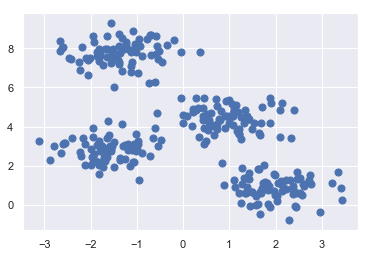

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

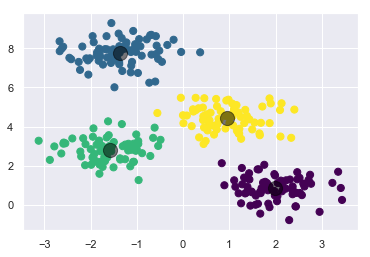

In [4]:
# plotting data colored by labels we found + cluster centers
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

But how does k-Means find these groupings so quickly? Clearly, going through all possible combinations would take a lot. To understand this, we have to understand **expectation–maximization**.

### k-Means Algorithm: Expectation–Maximization

In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
    * E-Step: assign points to the nearest cluster center
    * M-Step: set the cluster centers to the mean

The k-Means algorithm is simple enough that we can write it in a few lines of code:

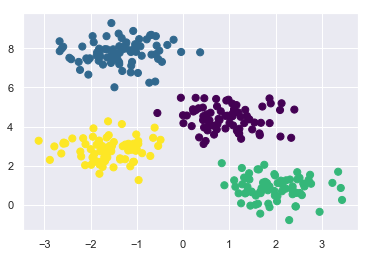

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### Caveats of expectation–maximization

**1. The globally optimum result may not be achieved**

In this case, it would be useful to run the algorithm multiple times, as Scikit-learn already does by default. 

**2. The number of clusters must be selected beforehand**

k-means cannot learn the number of clusters from the data. 

**3. k-means is limited to linear cluster boundaries**

The algorithm will often be ineffective if the clusters have complicated geometries. In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries. 

In [6]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

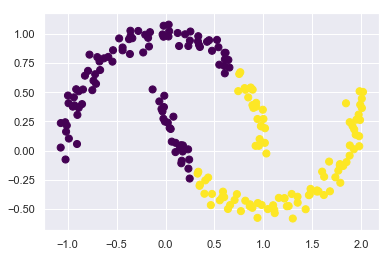

In [7]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

One way to overcome this limitation is to project the data into a higher dimension where a linear separation is possible. 

C:\Users\Giuseppe\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


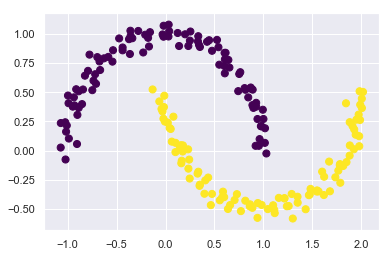

In [8]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

**4. k-means can be slow for large numbers of samples**

To overcome this, we might just use a subset of the data to update the cluster centers at each step. This is the idea behind _batch-based k-means algorithms_, one form of which is implemented in <code>sklearn.cluster.MiniBatchKMeans</code>.